In [54]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [55]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [56]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [57]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [58]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [59]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [60]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [61]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [62]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [63]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x = np.hstack((t, hh, bb, total_coords))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [64]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [65]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [66]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [67]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [68]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [69]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [70]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [71]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - airfoil coordinates:  (80000, 100)
Dimension - coord with flaps:  (80000, 10)
Dimension - total coordinates:  (80000, 110)
Dimension - x:  (80000, 113)
Dimension - y:  (80000, 1)


In [72]:
x[:5,:5]

array([[1.00000000e+01, 0.00000000e+00, 0.00000000e+00, 4.27163750e-03,
        8.42233786e-03],
       [1.00010000e+01, 0.00000000e+00, 0.00000000e+00, 4.27163750e-03,
        8.42233786e-03],
       [1.00020000e+01, 0.00000000e+00, 0.00000000e+00, 4.27163750e-03,
        8.42233786e-03],
       [1.00030000e+01, 0.00000000e+00, 0.00000000e+00, 4.27163750e-03,
        8.42233786e-03],
       [1.00040000e+01, 0.00000000e+00, 0.00000000e+00, 4.27163750e-03,
        8.42233786e-03]])

In [73]:
cm[:5]

array([[0.038717  ],
       [0.038266  ],
       [0.037764  ],
       [0.03750899],
       [0.037234  ]])

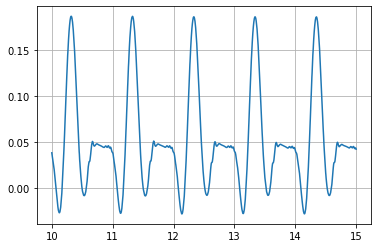

In [74]:
plt.plot(x[:5000,0],cm[:5000])
plt.grid()

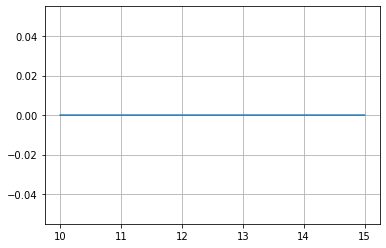

In [75]:
plt.plot(x[:5000,0],x[:5000,1])
plt.grid()

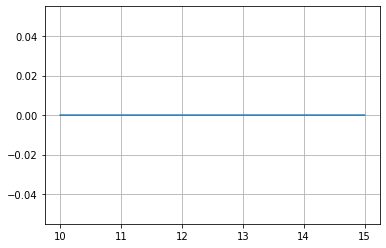

In [76]:
plt.plot(x[:5000,0],x[:5000,2])
plt.grid()

In [77]:
x[:5000, :].shape

(5000, 113)

In [78]:
def dataset_split(x, y, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate),  random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test

In [79]:
x_train, x_val, x_test, y_train, y_val, y_test = dataset_split(x[:5000,:], y[:5000,:], test_rate, val_rate=val_rate, validation=True, random_state=26)

In [80]:
x_train.shape

(3499, 113)

In [81]:
x_train[0,:]

array([ 1.13230000e+01,  0.00000000e+00,  0.00000000e+00,  4.27163750e-03,
        8.42233786e-03,  1.24698102e-02,  1.64215642e-02,  2.02769784e-02,
        2.40405173e-02,  2.77159894e-02,  3.13048084e-02,  3.48028987e-02,
        3.82178940e-02,  4.15541698e-02,  4.48033660e-02,  4.79746630e-02,
        5.10596164e-02,  5.40608993e-02,  5.69839150e-02,  5.98111069e-02,
        6.25547652e-02,  6.52095713e-02,  6.77573919e-02,  7.02132162e-02,
        7.25691930e-02,  7.48052747e-02,  7.69256294e-02,  7.89274580e-02,
        8.08033541e-02,  8.25249766e-02,  8.41042116e-02,  8.55329314e-02,
        8.67823675e-02,  8.78450936e-02,  8.87219878e-02,  8.93836883e-02,
        8.98055634e-02,  8.99969955e-02,  8.99055367e-02,  8.95254756e-02,
        8.88320811e-02,  8.77731379e-02,  8.63376094e-02,  8.44669978e-02,
        8.20983040e-02,  7.91920393e-02,  7.56532077e-02,  7.13421891e-02,
        6.61051824e-02,  5.97000072e-02,  5.17594768e-02,  4.14328713e-02,
        2.68996353e-02, -

In [82]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [83]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257 

In [84]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [85]:
model_directory = "D:\\TrainedModels\\20221219_noflap"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [89]:
ckpt_name = model_directory + "20221219unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [87]:
STEP_SIZE_TRAIN = len(x)//batch_size
VALIDATION_STEPS = len(x)//batch_size

In [91]:
start = datetime.datetime.now()
history = model.fit(x[:5000,0], cm[:5000], batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
80/80 [==============================] - 1s 7ms/step - loss: 0.0038 - rmse: 0.0602 - lr: 1.0000e-04
Epoch 2/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0039 - rmse: 0.0616 - lr: 1.0000e-04
Epoch 3/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0038 - rmse: 0.0602 - lr: 1.0000e-04
Epoch 4/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0056 - rmse: 0.0742 - lr: 1.0000e-04
Epoch 5/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0089 - rmse: 0.0935 - lr: 1.0000e-04
Epoch 6/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0061 - rmse: 0.0771 - lr: 1.0000e-04
Epoch 7/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0044 - rmse: 0.0650 - lr: 1.0000e-04
Epoch 8/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.2255 - rmse: 0.4747 - lr: 1.0000e-04
Epoch 9/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0034 - rmse

80/80 [==============================] - 0s 6ms/step - loss: 0.0042 - rmse: 0.0640 - lr: 1.0000e-04
Epoch 73/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0221 - rmse: 0.1483 - lr: 1.0000e-04
Epoch 74/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0040 - rmse: 0.0623 - lr: 1.0000e-04
Epoch 75/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0427 - rmse: 0.2065 - lr: 1.0000e-04
Epoch 76/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0083 - rmse: 0.0904 - lr: 1.0000e-04
Epoch 77/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0044 - rmse: 0.0653 - lr: 1.0000e-04
Epoch 78/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0053 - rmse: 0.0725 - lr: 1.0000e-04
Epoch 79/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0059 - rmse: 0.0759 - lr: 1.0000e-04
Epoch 80/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0077 - rmse: 0.08

Epoch 143/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0043 - rmse: 0.0651 - lr: 1.0000e-04
Epoch 144/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0054 - rmse: 0.0730 - lr: 1.0000e-04
Epoch 145/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0043 - rmse: 0.0652 - lr: 1.0000e-04
Epoch 146/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0126 - rmse: 0.1121 - lr: 1.0000e-04
Epoch 147/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0040 - rmse: 0.0628 - lr: 1.0000e-04
Epoch 148/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0080 - rmse: 0.0892 - lr: 1.0000e-04
Epoch 149/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0071 - rmse: 0.0837 - lr: 1.0000e-04
Epoch 150/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0056 - rmse: 0.0740 - lr: 1.0000e-04
Epoch 151/10000
80/80 [==============================] - 0s 6ms/step - l

80/80 [==============================] - 0s 6ms/step - loss: 0.0037 - rmse: 0.0604 - lr: 5.0000e-05
Epoch 213/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0042 - rmse: 0.0640 - lr: 5.0000e-05
Epoch 214/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0039 - rmse: 0.0615 - lr: 5.0000e-05
Epoch 215/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0042 - rmse: 0.0644 - lr: 5.0000e-05
Epoch 216/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0050 - rmse: 0.0703 - lr: 5.0000e-05
Epoch 217/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0586 - lr: 5.0000e-05
Epoch 218/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0040 - rmse: 0.0626 - lr: 5.0000e-05
Epoch 219/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0038 - rmse: 0.0606 - lr: 5.0000e-05
Epoch 220/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0043 - rm

80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0555 - lr: 2.5000e-05
Epoch 282/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0563 - lr: 2.5000e-05
Epoch 283/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0565 - lr: 2.5000e-05
Epoch 284/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0572 - lr: 2.5000e-05
Epoch 285/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0566 - lr: 2.5000e-05
Epoch 286/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0559 - lr: 2.5000e-05
Epoch 287/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0559 - lr: 2.5000e-05
Epoch 288/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0569 - lr: 2.5000e-05
Epoch 289/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0034 - rm

80/80 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0582 - lr: 2.5000e-05
Epoch 352/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0034 - rmse: 0.0575 - lr: 2.5000e-05
Epoch 353/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0036 - rmse: 0.0597 - lr: 2.5000e-05
Epoch 354/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0569 - lr: 2.5000e-05
Epoch 355/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0570 - lr: 2.5000e-05
Epoch 356/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0571 - lr: 2.5000e-05
Epoch 357/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0566 - lr: 2.5000e-05
Epoch 358/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0568 - lr: 2.5000e-05
Epoch 359/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0034 - rm

80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0565 - lr: 1.2500e-05
Epoch 421/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0568 - lr: 1.2500e-05
Epoch 422/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0563 - lr: 1.2500e-05
Epoch 423/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0560 - lr: 1.2500e-05
Epoch 424/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0566 - lr: 1.2500e-05
Epoch 425/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0560 - lr: 1.2500e-05
Epoch 426/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0560 - lr: 1.2500e-05
Epoch 427/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0562 - lr: 1.2500e-05
Epoch 428/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rm

80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0556 - lr: 6.2500e-06
Epoch 490/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0555 - lr: 6.2500e-06
Epoch 491/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0031 - rmse: 0.0555 - lr: 6.2500e-06
Epoch 492/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0558 - lr: 6.2500e-06
Epoch 493/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0031 - rmse: 0.0554 - lr: 6.2500e-06
Epoch 494/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0555 - lr: 6.2500e-06
Epoch 495/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0555 - lr: 6.2500e-06
Epoch 496/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0557 - lr: 6.2500e-06
Epoch 497/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rm

80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0557 - lr: 6.2500e-06
Epoch 560/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0558 - lr: 6.2500e-06
Epoch 561/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0558 - lr: 6.2500e-06
Epoch 562/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0555 - lr: 6.2500e-06
Epoch 563/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0558 - lr: 6.2500e-06
Epoch 564/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0561 - lr: 6.2500e-06
Epoch 565/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0560 - lr: 6.2500e-06
Epoch 566/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0557 - lr: 6.2500e-06
Epoch 567/10000
80/80 [==============================] - 0s 6ms/step - loss: 0.0032 - rm

In [92]:
time = end - start
print("Training time:", time)

Training time: 0:04:46.200489


In [39]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221219_noFlapMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"unitsCmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

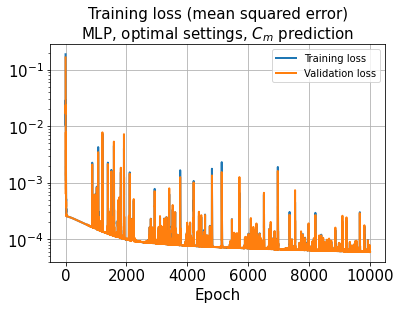

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

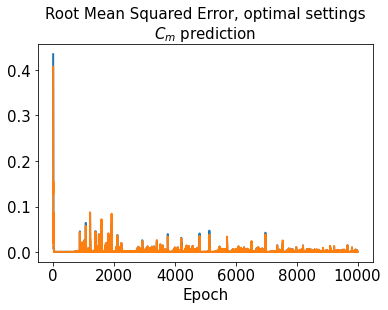

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

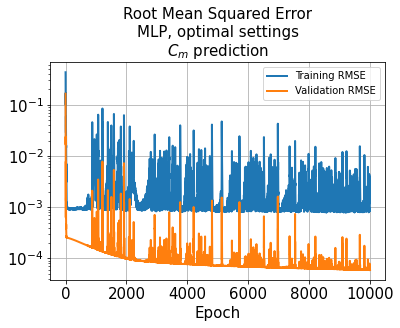

In [42]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 5.9674e-05 - rmse: 8.0719e-04


In [44]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 5.9693e-05 - rmse: 8.1916e-04


In [45]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 5.9641e-05 - rmse: 7.8684e-04


In [46]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [82]:
decoded_train_

array([[0.00152917],
       [0.00162144],
       [0.00151195],
       ...,
       [0.00157808],
       [0.00176756],
       [0.00143046]], dtype=float32)

In [93]:
decoded_train_ = model.predict(x[:5000,0])

157/157 [==============================] - 0s 2ms/step


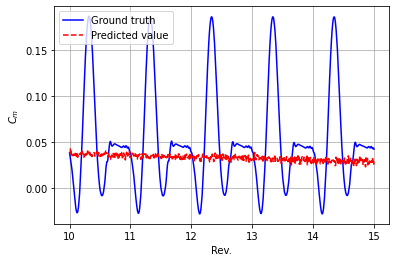

In [99]:
plt.plot(x[:5000,0], cm[:5000], 'b-', label='Ground truth')
plt.plot(x[:5000,0], decoded_train_[:5000], 'r--', label='Predicted value')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')     
plt.legend(loc='upper left')

plt.grid()
plt.show()

In [100]:
t = np.pi*x[:5000,0]

In [101]:
y = np.sin(t)

In [102]:
model2 = make_mlp_model(num_layer=n_layers)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257 

In [104]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [105]:
start = datetime.datetime.now()
history = model2.fit(t, y, batch_size=batch_size,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 0s 9ms/step - loss: 747.4107 - rmse: 27.3388 - lr: 1.0000e-04
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 358.4746 - rmse: 18.9334 - lr: 1.0000e-04
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 89.8547 - rmse: 9.4792 - lr: 1.0000e-04
Epoch 4/10000
5/5 [==============================] - 0s 9ms/step - loss: 75.9831 - rmse: 8.7168 - lr: 1.0000e-04
Epoch 5/10000
5/5 [==============================] - 0s 9ms/step - loss: 52.7061 - rmse: 7.2599 - lr: 1.0000e-04
Epoch 6/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.5843 - rmse: 3.9477 - lr: 1.0000e-04
Epoch 7/10000
5/5 [==============================] - 0s 8ms/step - loss: 24.2670 - rmse: 4.9261 - lr: 1.0000e-04
Epoch 8/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.1067 - rmse: 2.4711 - lr: 1.0000e-04
Epoch 9/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.7790 - rmse: 2.60

5/5 [==============================] - 0s 7ms/step - loss: 0.4869 - rmse: 0.6976 - lr: 1.0000e-04
Epoch 74/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4868 - rmse: 0.6976 - lr: 1.0000e-04
Epoch 75/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4861 - rmse: 0.6971 - lr: 1.0000e-04
Epoch 76/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4871 - rmse: 0.6978 - lr: 1.0000e-04
Epoch 77/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4878 - rmse: 0.6982 - lr: 1.0000e-04
Epoch 78/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4871 - rmse: 0.6977 - lr: 1.0000e-04
Epoch 79/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4861 - rmse: 0.6970 - lr: 1.0000e-04
Epoch 80/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4864 - rmse: 0.6972 - lr: 1.0000e-04
Epoch 81/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4868 - rmse: 0.6976 - lr: 1.0000e-0

Epoch 144/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4853 - rmse: 0.6965 - lr: 5.0000e-05
Epoch 145/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4877 - rmse: 0.6982 - lr: 5.0000e-05
Epoch 146/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4859 - rmse: 0.6969 - lr: 5.0000e-05
Epoch 147/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4858 - rmse: 0.6968 - lr: 5.0000e-05
Epoch 148/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4862 - rmse: 0.6971 - lr: 5.0000e-05
Epoch 149/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4862 - rmse: 0.6971 - lr: 5.0000e-05
Epoch 150/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4856 - rmse: 0.6967 - lr: 5.0000e-05
Epoch 151/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4859 - rmse: 0.6969 - lr: 5.0000e-05
Epoch 152/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4863 - rmse

Epoch 216/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4857 - rmse: 0.6968 - lr: 5.0000e-05
Epoch 217/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4844 - rmse: 0.6958 - lr: 5.0000e-05
Epoch 218/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4863 - rmse: 0.6972 - lr: 5.0000e-05
Epoch 219/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4864 - rmse: 0.6972 - lr: 5.0000e-05
Epoch 220/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4877 - rmse: 0.6982 - lr: 5.0000e-05
Epoch 221/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4868 - rmse: 0.6976 - lr: 5.0000e-05
Epoch 222/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4861 - rmse: 0.6970 - lr: 5.0000e-05
Epoch 223/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4857 - rmse: 0.6968 - lr: 5.0000e-05
Epoch 224/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4857 - rmse

Epoch 288/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4866 - rmse: 0.6974 - lr: 5.0000e-05
Epoch 289/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4863 - rmse: 0.6972 - lr: 5.0000e-05
Epoch 290/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4859 - rmse: 0.6969 - lr: 5.0000e-05
Epoch 291/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4855 - rmse: 0.6966 - lr: 5.0000e-05
Epoch 292/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4860 - rmse: 0.6970 - lr: 5.0000e-05
Epoch 293/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4864 - rmse: 0.6973 - lr: 5.0000e-05
Epoch 294/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4854 - rmse: 0.6965 - lr: 5.0000e-05
Epoch 295/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4863 - rmse: 0.6972 - lr: 5.0000e-05
Epoch 296/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4858 - rmse

5/5 [==============================] - 0s 6ms/step - loss: 0.4863 - rmse: 0.6972 - lr: 2.5000e-05
Epoch 359/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4860 - rmse: 0.6970 - lr: 2.5000e-05
Epoch 360/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4864 - rmse: 0.6973 - lr: 2.5000e-05
Epoch 361/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4863 - rmse: 0.6972 - lr: 2.5000e-05
Epoch 362/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4871 - rmse: 0.6978 - lr: 2.5000e-05
Epoch 363/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4859 - rmse: 0.6969 - lr: 2.5000e-05
Epoch 364/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4862 - rmse: 0.6971 - lr: 2.5000e-05
Epoch 365/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4872 - rmse: 0.6978 - lr: 2.5000e-05
Epoch 366/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4866 - rmse: 0.6974 - lr: 2

5/5 [==============================] - 0s 7ms/step - loss: 0.4867 - rmse: 0.6975 - lr: 1.2500e-05
Epoch 429/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4872 - rmse: 0.6978 - lr: 1.2500e-05
Epoch 430/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4869 - rmse: 0.6977 - lr: 1.2500e-05
Epoch 431/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4863 - rmse: 0.6972 - lr: 1.2500e-05
Epoch 432/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4866 - rmse: 0.6974 - lr: 1.2500e-05
Epoch 433/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4871 - rmse: 0.6978 - lr: 1.2500e-05
Epoch 434/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4872 - rmse: 0.6979 - lr: 1.2500e-05
Epoch 435/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4870 - rmse: 0.6977 - lr: 1.2500e-05
Epoch 436/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4869 - rmse: 0.6976 - lr: 1

5/5 [==============================] - 0s 6ms/step - loss: 0.4862 - rmse: 0.6971 - lr: 1.2500e-05
Epoch 501/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4866 - rmse: 0.6974 - lr: 1.2500e-05
Epoch 502/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4856 - rmse: 0.6967 - lr: 1.2500e-05
Epoch 503/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4858 - rmse: 0.6969 - lr: 1.2500e-05
Epoch 504/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4864 - rmse: 0.6973 - lr: 1.2500e-05
Epoch 505/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4863 - rmse: 0.6972 - lr: 1.2500e-05
Epoch 506/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4861 - rmse: 0.6971 - lr: 1.2500e-05
Epoch 507/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4867 - rmse: 0.6975 - lr: 1.2500e-05
Epoch 508/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4868 - rmse: 0.6976 - lr: 1

5/5 [==============================] - 0s 6ms/step - loss: 0.4860 - rmse: 0.6970 - lr: 6.2500e-06
Epoch 571/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4866 - rmse: 0.6974 - lr: 6.2500e-06
Epoch 572/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4865 - rmse: 0.6973 - lr: 6.2500e-06
Epoch 573/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4867 - rmse: 0.6975 - lr: 6.2500e-06
Epoch 574/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4862 - rmse: 0.6971 - lr: 6.2500e-06
Epoch 575/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4856 - rmse: 0.6967 - lr: 6.2500e-06
Epoch 576/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4858 - rmse: 0.6969 - lr: 6.2500e-06
Epoch 577/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4854 - rmse: 0.6966 - lr: 6.2500e-06
Epoch 578/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4856 - rmse: 0.6967 - lr: 6

5/5 [==============================] - 0s 6ms/step - loss: 0.4858 - rmse: 0.6968 - lr: 3.1250e-06
Epoch 641/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.4861 - rmse: 0.6971 - lr: 3.1250e-06
Epoch 642/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4866 - rmse: 0.6974 - lr: 3.1250e-06
Epoch 643/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4865 - rmse: 0.6974 - lr: 3.1250e-06
Epoch 644/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4863 - rmse: 0.6972 - lr: 3.1250e-06
Epoch 645/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4864 - rmse: 0.6973 - lr: 3.1250e-06
Epoch 646/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4866 - rmse: 0.6974 - lr: 3.1250e-06
Epoch 647/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4868 - rmse: 0.6976 - lr: 3.1250e-06
Epoch 648/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.4864 - rmse: 0.6973 - lr: 3


Epoch 711: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
5/5 [==============================] - 0s 8ms/step - loss: 0.4854 - rmse: 0.6966 - lr: 3.1250e-06
Epoch 711: early stopping


In [106]:
decode = model2.predict(t)

157/157 [==============================] - 0s 2ms/step


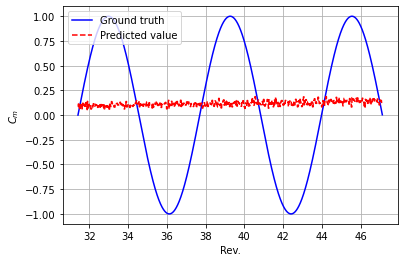

In [108]:
plt.plot(t, y[:5000], 'b-', label='Ground truth')
plt.plot(t, decode[:5000], 'r--', label='Predicted value')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')     
plt.legend(loc='upper left')

plt.grid()
plt.show()

In [47]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [48]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [49]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [50]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [51]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [52]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [53]:
model_directory = "D:\\TrainedModels\\20221219"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221219unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"unitsCmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [54]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [55]:
os.chdir(storage_dir)

In [56]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [57]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = mape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.7540889022888687
845.2358061309495


In [58]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= mape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.7644156206711136
500.34377238388936


In [59]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= mape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.7501638773182464
449.94831916781226


In [60]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [61]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [62]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [63]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = mape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [64]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = mape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [65]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = mape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [66]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

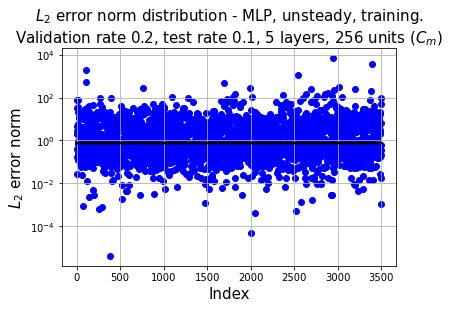

In [67]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

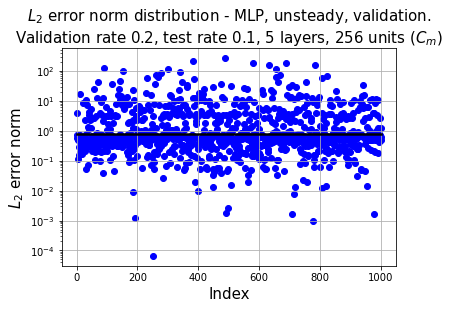

In [68]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

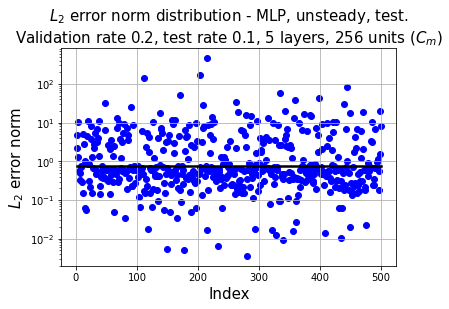

In [69]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [87]:
predicted = model.predict(x[:5000])

157/157 [==============================] - 0s 2ms/step


In [88]:
np.max(x)

14.99899999999723

In [95]:
predicted.shape

(5000, 1)

In [89]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [90]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [91]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [92]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], Cm, 'k-', label='Ground truth')
    plt.plot(t[:5000], cm, 'k--', label='Predicted value')
    plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, iTest, color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.4572


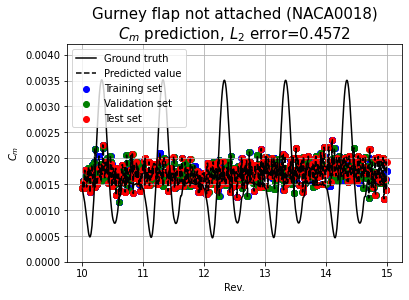

In [119]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 1):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)